(compose_own_plot)=
# Create your own figure with `PlotCollection`

This tutorial covers how to use `PlotCollection` to simplify the creation of bespoke visualizations. We will cover how to create `PlotCollection` classes directly and two common strategies to fill your {term}`figure` using your `PlotCollection` instance.

## `PlotCollection` design overview
The main goal of the `PlotCollection` class is to allow you to write plotting functions that are purely plotting functions. No need to worry about {term}`faceting` or {term}`aesthetic mappings`.

You can then generate a `PlotCollection` with the {term}`faceting` strategy and {term}`aesthetic mappings` you want and apply those functions through {meth}`~arviz_plots.PlotCollection.map`. `.map` will subset your data and pass each subset along with its corresponding {term}`plot` and {term}`aesthetics` to your function as many times as needed.

## Tutorial data overview

In [1]:
import arviz_stats as azs
import arviz_plots as azp

azp.style.use("arviz-variat")

In [2]:
import pandas as pd
import numpy as np
import pymc as pm
import xarray as xr

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# generate data ------------------------------------------------------------------------
n_groups = 4
group_size = [2, 4, 6, 8]

# Group-specific parameters
slopes = rng.normal(1, 0.2, size=n_groups)
intercepts = rng.normal(0, 1, size=n_groups)

# Generate data
data = []
for i in range(n_groups):
    n = group_size[i]
    x_vals = np.sort(rng.uniform(0, 20, size=n))
    noise = rng.normal(0, 1, size=n)
    y_vals = slopes[i] * x_vals + intercepts[i] + noise
    group_labels = np.full(n, i)
    data.append(pd.DataFrame({"x": x_vals, "y": y_vals, "group": group_labels}))

# Combine all groups into a single DataFrame
df = pd.concat(data, ignore_index=True)
df["group"] = df["group"].astype("category")

# Build a PyMC model -------------------------------------------------------------------
prior_mean = 0
prior_std = 1

x_data = df.x.values
y_data = df.y.values

coords = {"groups": df["group"].cat.categories, "obs_id": df.index}

with pm.Model(coords=coords) as model:
    x = pm.Data("x", x_data, dims="obs_id")
    y = pm.Data("y", y_data, dims="obs_id")
    group = pm.Data("group", df["group"].cat.codes.values, dims="obs_id")
    # priors
    intercept = pm.Normal("intercept", mu=0, sigma=10, dims=["groups"])
    beta = pm.Normal("beta", mu=prior_mean, sigma=prior_std, dims=["groups"])
    sigma = pm.HalfNormal("sigma", sigma=5)
    # likelihood
    mu = pm.Deterministic("mu", intercept[group] + beta[group] * x, dims="obs_id")
    pm.Normal("obs", mu=mu, sigma=sigma, observed=y, dims="obs_id")
    # sample
    idata = pm.sample()

# Generate a grid of points to evaluate on ---------------------------------------------
n_interp_points = 20
xi = np.concatenate(
    [
        np.linspace(group[1].x.min(), group[1].x.max(), n_interp_points)
        for group in df.groupby("group")
    ]
)
g = np.concatenate([[i] * n_interp_points for i in range(n_groups)]).astype(int)
predict_at = {"x": xi, "group": g, "y": np.zeros_like(xi)}

# Posterior prediction on the grid of points -------------------------------------------
coords = {"groups": predict_at["group"], "obs_id": np.arange(len(xi))}

with model:
    pm.set_data(predict_at, coords=coords)
    idata.extend(
        pm.sample_posterior_predictive(
            idata,
            var_names=["mu"],
            random_seed=rng,
            progressbar=False,
            predictions=True,
        )
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
/tmp/ipykernel_21498/176044696.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group in df.groupby("group")
Sampling: []


Our data for the tutorial is a regression model with unpooled slope and intercept; each `group` has their own regression coefficients. Moreover, the number of observations within each group is different. Therefore, we can't have `group` as a dimension of our data. We could have, and actually had, a `group` dimension in some of the model parameters. For the data we add that information as coordinate values of the `obs_id` dimension which represents individual observations:

In [3]:
data = xr.merge((idata.constant_data, idata.observed_data)).set_coords("group")
data

<xarray.Dataset> Size: 560B
Dimensions:  (obs_id: 20)
Coordinates:
  * obs_id   (obs_id) int64 160B 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
    group    (obs_id) int32 80B 0 0 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 3 3
Data variables:
    x        (obs_id) float64 160B 2.562 9.008 4.545 8.868 ... 9.391 9.514 13.4
    obs      (obs_id) float64 160B 1.647 8.383 2.666 4.763 ... 11.06 11.86 15.82
Attributes:
    created_at:                 2025-06-15T13:36:41.922640+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.22.0

We also define a linspace over the `x` values on which to predict for a dense grid. Thus we also have a `pred_data` Dataset, which holds the input grid over which predicitons were made, and a `predictions` Dataset, which holds these predictions. In each of these Datasets we were careful to use the same `group` coordinate. Note, however, that although the set of labels is the same as `data`, the values are now different, and correspond to the prediction data!

:::{note}
For the predictions, we use different linspaces for each group but they all have the same number of elements, so it would be possible to use {func}`~xarray_einstats.einops.rearrange` to reshape the data into `(group, obs_id)` shape. As that is not necessary to use the data with `PlotCollection` we will stick to using the extra coordinate with the group factors.
:::

In [4]:
pred_data = idata.predictions_constant_data.set_coords("group")
pred_data

<xarray.Dataset> Size: 2kB
Dimensions:  (obs_id: 80)
Coordinates:
  * obs_id   (obs_id) int64 640B 0 1 2 3 4 5 6 7 8 ... 72 73 74 75 76 77 78 79
    group    (obs_id) int32 320B 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
Data variables:
    x        (obs_id) float64 640B 2.562 2.902 3.241 3.58 ... 12.26 12.83 13.4
Attributes:
    created_at:                 2025-06-15T13:36:42.180582+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.22.0

In [5]:
predictions = idata.predictions.assign_coords(group=pred_data["group"])
predictions

<xarray.Dataset> Size: 3MB
Dimensions:  (chain: 4, draw: 1000, obs_id: 80)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_id   (obs_id) int64 640B 0 1 2 3 4 5 6 7 8 ... 72 73 74 75 76 77 78 79
    group    (obs_id) int32 320B 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
Data variables:
    mu       (chain, draw, obs_id) float64 3MB 1.84 2.164 2.488 ... 15.53 16.2
Attributes:
    created_at:                 2025-06-15T13:36:42.177192+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.22.0

## Initializing a `PlotCollection`

The two main ways to initialize a `PlotCollection` are {meth}`~arviz_plots.PlotCollection.grid` and {meth}`~arviz_plots.PlotCollection.wrap`. Which method you choose defines the faceting strategy. The specific faceting depends on the `cols`, `rows` and `col_wrap` arguments, and {term}`aesthetic mappings` are defined in the same way independently of the method.

In this section, we will use the two approaches above interchangeably to show that they both produce the same results.

### Defining the faceting
We can use {meth}`~arviz_plots.PlotCollection.grid` to generate columns of {term}`plots` per group. If we map nothing to the rows we'll get 4 plots total, one per group:

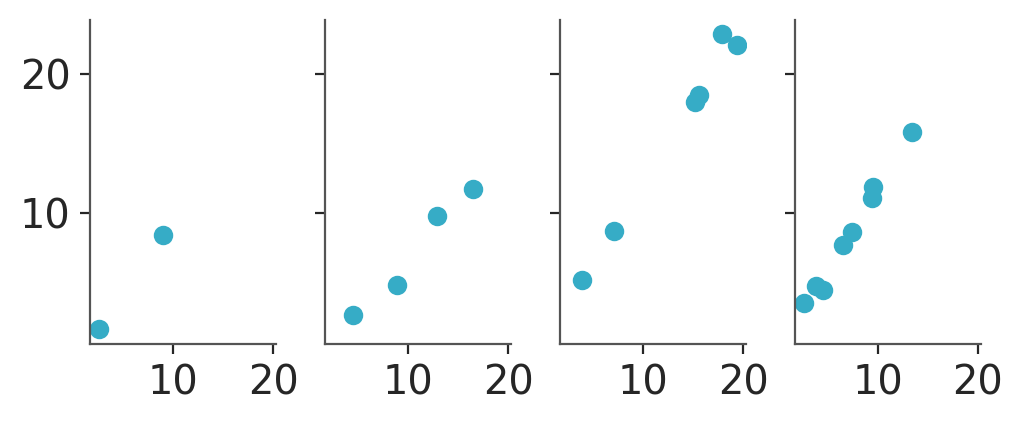

In [6]:
pc = azp.PlotCollection.grid(
    data[["obs"]],
    cols=["group"],
    figure_kwargs={"sharex": True, "sharey": True, "figsize": (5, 2)}
)
pc.map(azp.visuals.scatter_xy, x=data["x"])

We can also use {meth}`~arviz_plots.PlotCollection.wrap` to generate a grid with a fixed number of columns and as many rows as needed.
If we set `col_wrap` to 3, we'll get 2 rows. The first one will have 3 plots and the 2nd will have only one plot so we get to our total of 4:

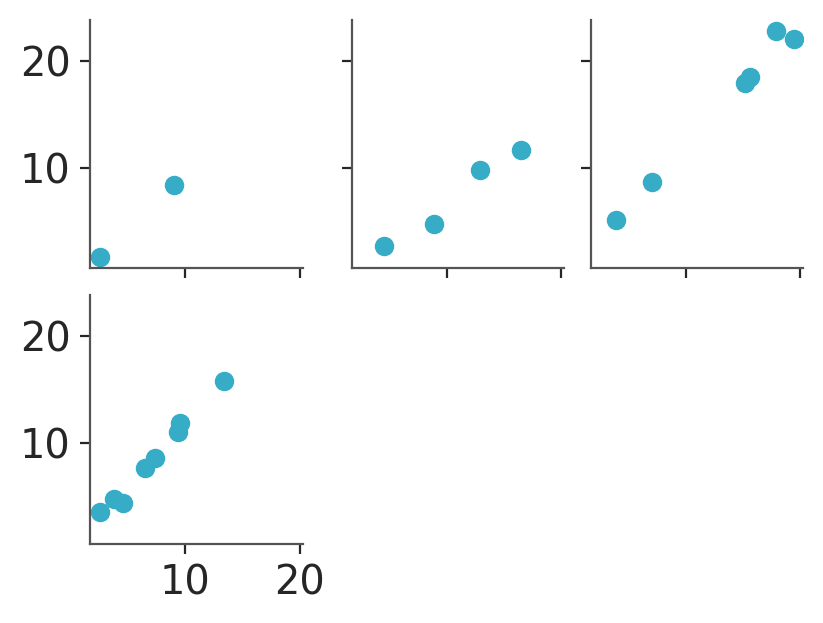

In [7]:
pc = azp.PlotCollection.wrap(
    data[["obs"]],
    cols=["group"],
    col_wrap=3,
    figure_kwargs={"sharex": True, "sharey": True, "figsize": (4, 3)}
)
pc.map(azp.visuals.scatter_xy, x=data["x"])

We can also use `.grid` to generate one plot per combination of `group` and `chain` -> 16 total. In this case we'll use the average regression lines in `prediction`. We'll reduce only the "draw" dimension when averaging so our data still has the "chain" dimension for us to facet along.

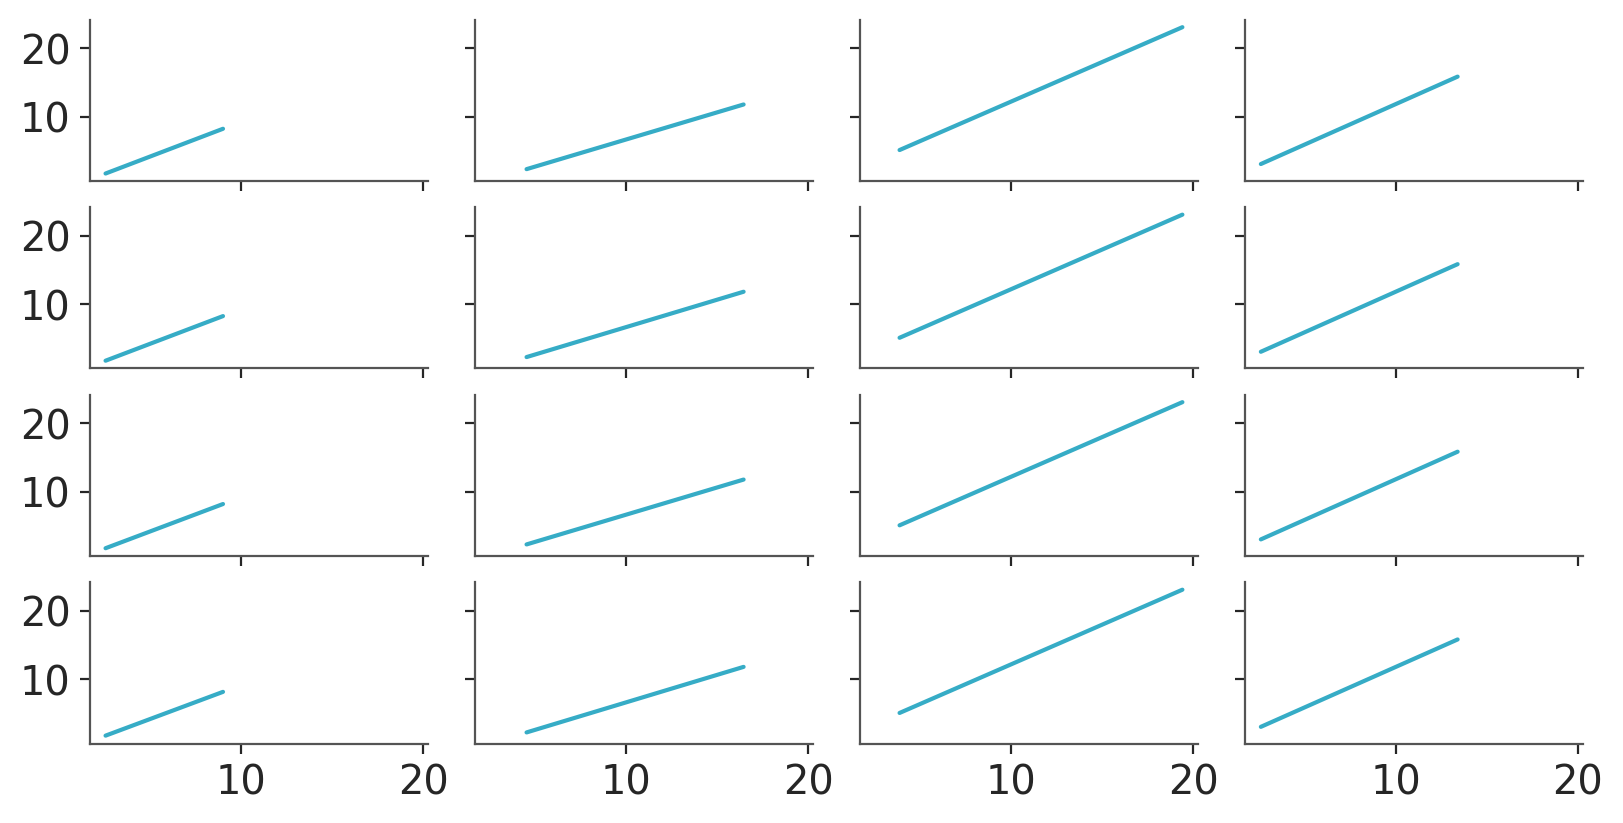

In [8]:
pc = azp.PlotCollection.grid(
    predictions.mean("draw"),
    cols=["group"],
    rows=["chain"],
    figure_kwargs={"sharex": True, "sharey": True, "figsize": (8, 4)}
)
pc.map(azp.visuals.line_xy, x=pred_data["x"])

### Defining the aesthetic mappings
Aesthetic mappings are always defined via the `aes` keyword argument of the `PlotCollection` initialization methods. It can be used on its own:

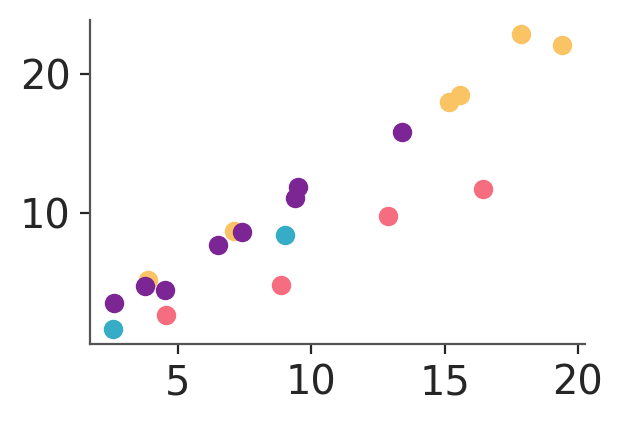

In [9]:
pc = azp.PlotCollection.grid(
    data[["obs"]],
    aes={"color": ["group"]},
    figure_kwargs={"figsize": (3, 2)}
)
pc.map(azp.visuals.scatter_xy, x=data["x"])

or combined with faceting:

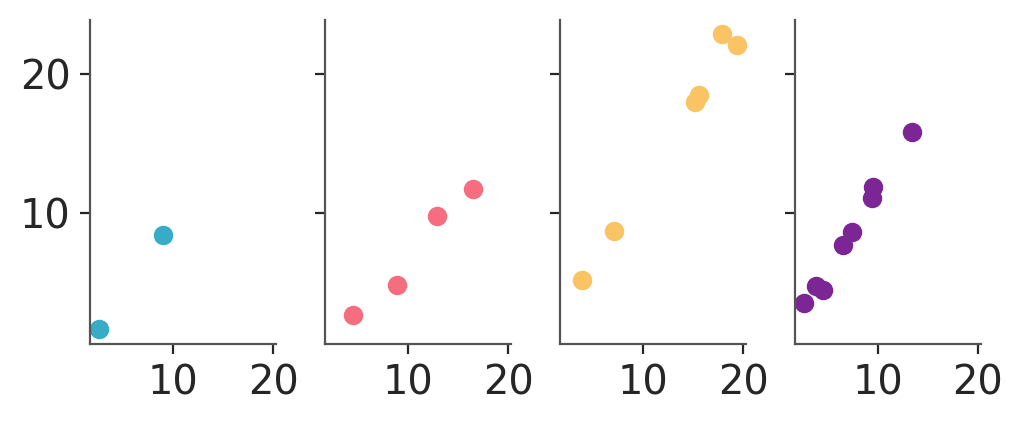

In [10]:
pc = azp.PlotCollection.grid(
    data[["obs"]],
    cols=["group"],
    aes={"color": ["group"]},
    figure_kwargs={"sharex": True, "sharey": True, "figsize": (5, 2)}
)
pc.map(azp.visuals.scatter_xy, x=data["x"])

Recall that faceting and aesthetics are independent mappings, allowing for highly flexible customization. For details on how to use those arguments, see `TODO: add reference`

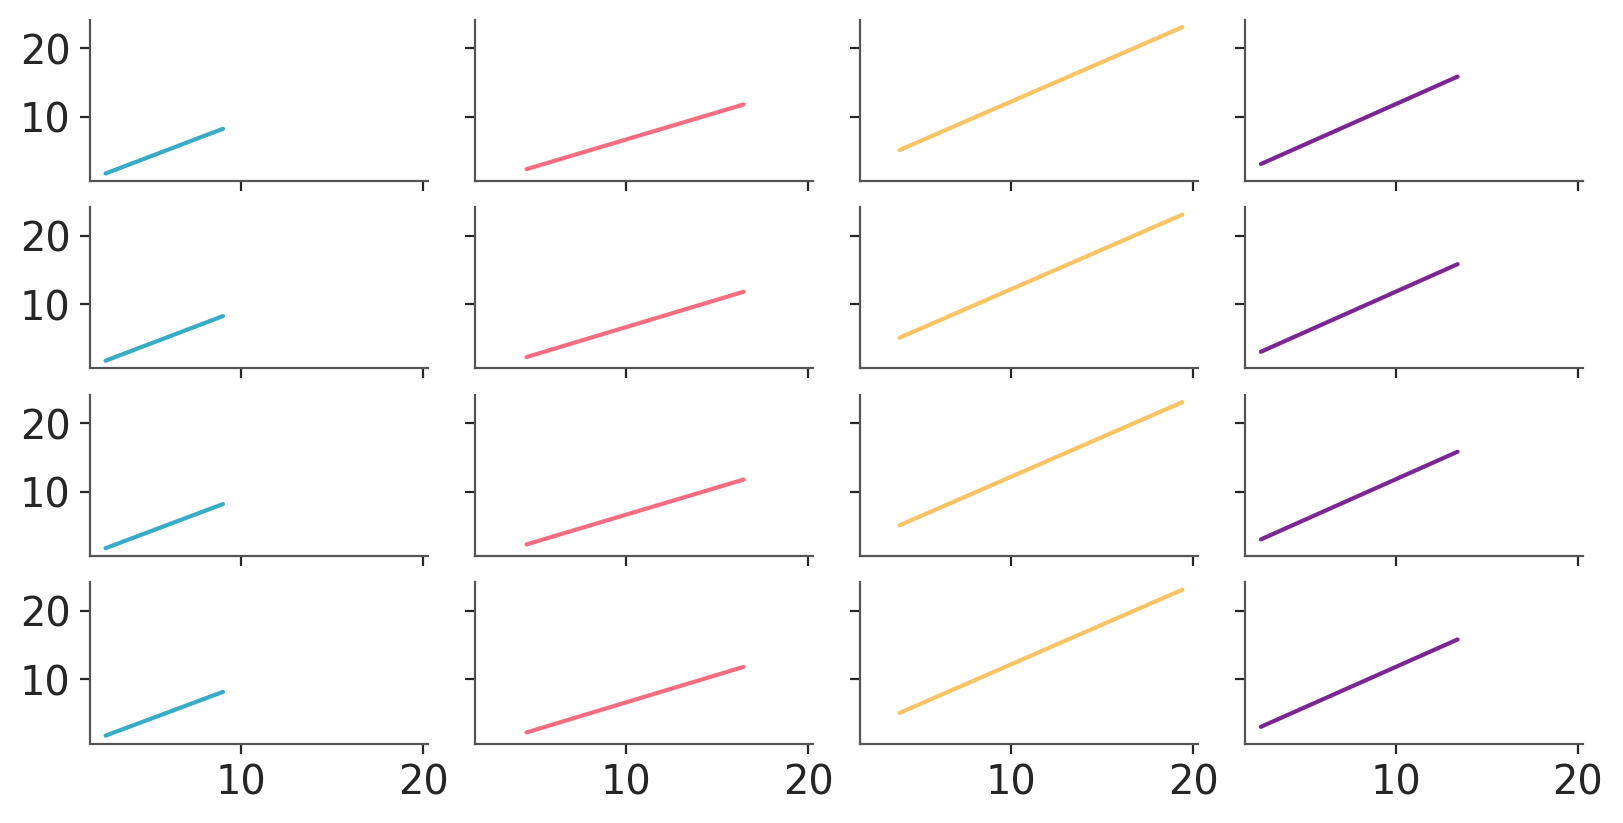

In [11]:
pc_chain = azp.PlotCollection.grid(
    predictions.mean("draw"),
    cols=["group"],
    rows=["chain"],
    aes={"color": ["group"]},
    figure_kwargs={"sharex": True, "sharey": True, "figsize": (8, 4)}
)
pc_chain.map(azp.visuals.line_xy, x=pred_data["x"])

## Writing your plotting function(s)
We want a plotting function that can be used through `PlotCollection.map`. As we have mentioned, `PlotCollection` subsets and ensures alignment between the data subsets, the {term}`plot` and the {term}`aesthetics`. Consequently, our function will need to accept at least these 3 elements. The expected call signature of `.map` compatible functions is `fn(da, target, ..., **kwargs)`.

* `da` is a {class}`~xarray.DataArray` a subset of the input data
* `target` is the plotting backend object representing the {term}`plot` corresponding to this subset
* `**kwargs` will contain the key-value pairs for all {term}`aesthetic mappings` corresponding to this subset

Other than that, it can be a single function that adds multiple {term}`visual elements <visuals>` at once or multiple visual specific functions or a combination of both. `arviz_plots` provides some visual specific functions in `arviz_plots.visuals`, but most bespoke visualizations will probably need something not available there.

As a first step to facilitate quick iteration, it can be better to use a monolithic function. Then as the visualization solidifies and more fine grained control is required, it becomes necessary to switch to visual-specific functions.
In this tutorial we will showcase the two approaches. To do so we will use a common regression plot with 3 elements: observation xy scatter, posterior mean regression line, and hdi band over the predicted distributions. and showcase the two approaches.

### Option 0: the for-loop workflow
In the previous ArviZ version, any custom plot that required faceting or aesthetic mappings meant you as a user had to manually take care of that. Legends also needed to be handled mostly manually by using the `label` argument or calling the legend generating function with custom graphical elements and labels.

Here is an example of overlaying all 4 groups on the same plot using a different color for each:

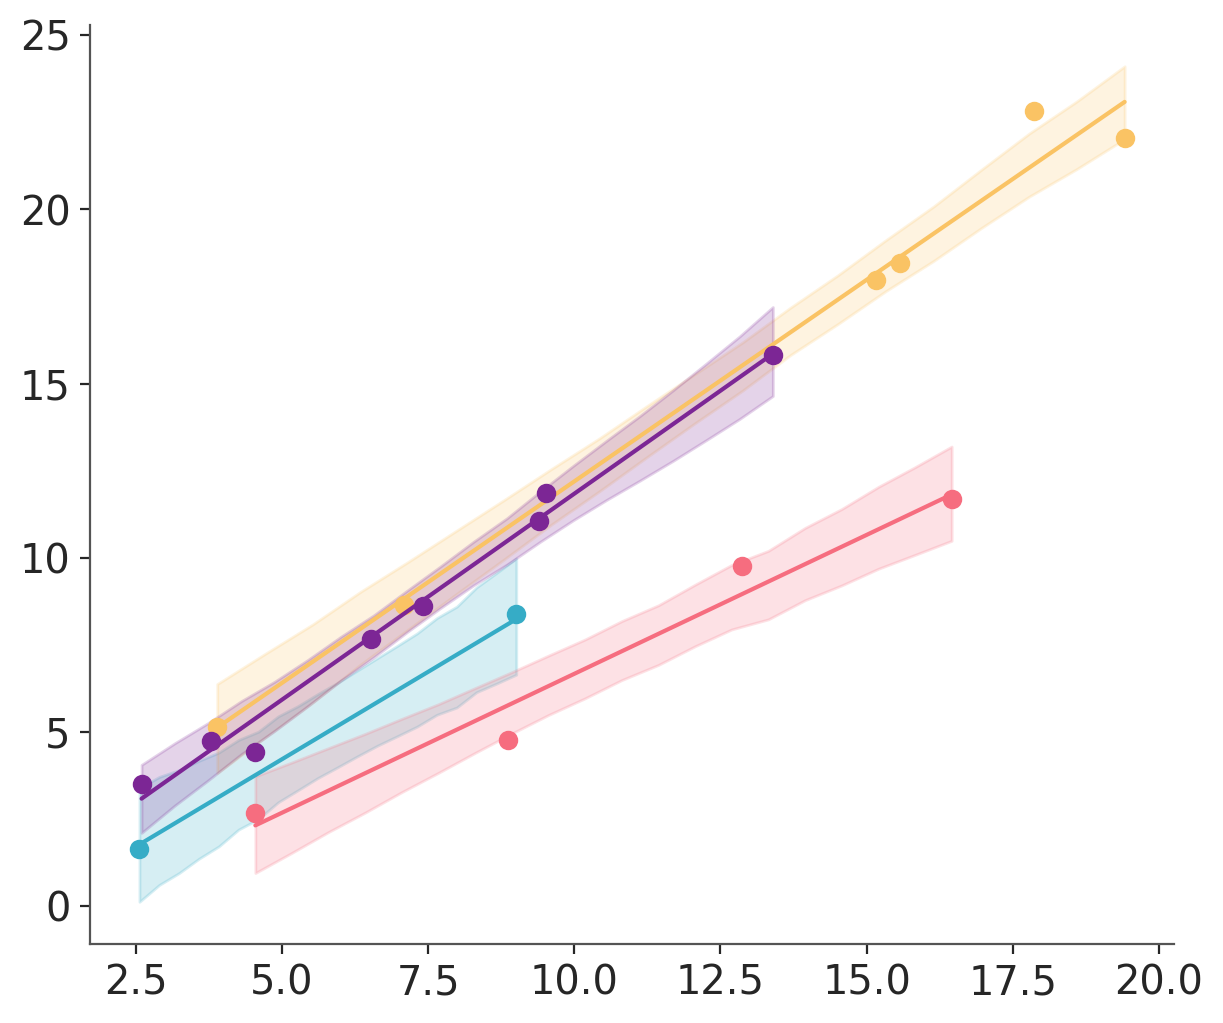

In [12]:
import matplotlib.pyplot as plt
import numpy as np

unique_groups = np.unique(data["group"])
colors = [f"C{i}" for i in range(len(unique_groups))]

fig, axes = plt.subplots(1, 1)  # if faceting subplots(1, 4) instead for example
for i, group in enumerate(unique_groups):
    # get subsets and corresponding plots+aesthetics
    data_subset = data.query(obs_id=f"group == {group}")
    pred_data_subset = pred_data.query(obs_id=f"group == {group}")
    predictions_subset = predictions.query(obs_id=f"group == {group}")
    ax = axes  # if faceting axes[i] instead for example
    color = colors[i]
    # start plotting
    mean = predictions_subset["mu"].mean(("chain", "draw"))
    ax.plot(data_subset["x"], data_subset["obs"], "o", color=color, label=f"Group {i}")
    ax.plot(pred_data_subset["x"], mean, color=color)
    # az.plot_hdi(pred_data_subset["x"], predictions_subset["mu"], color=color, ax=ax)
    # plot_hdi has no equivalent in arviz-plots
    # so we replicate its behaviour in this specific context
    hdi = predictions_subset["mu"].azstats.hdi()
    ax.fill_between(
        pred_data_subset["x"],
        hdi.sel(ci_bound="lower"),
        hdi.sel(ci_bound="upper"),
        color=color,
        alpha=0.2
    )

If using a pattern similar to this one, you should be able to copy anything after subsetting `data` and `axes` into a monolithic plotting function and use it through `PlotCollection` to easily change faceting and aesthetics without needing to modify the plotting code at all.

### Option 1: monolithic function
The monolithic function approach is best explained via example. In the next cell, we write a function that replaces "the for-loop workflow" illustrated above with a single call to `.map`.

In [13]:
def line_band_dots(da, target, x_pred, x, y, **kwargs):
    """Add mean line, hdi band and observation xy scatter to a matplotlib plot.

    Parameters
    ----------
    da : DataArray
        Predicted samples for the regression line mean and HDI band.
    target : matplotlib.axes.Axes
    x_pred : DataArray
        Independent variable used to generate the predicted samples
    x : DataArray
        Observed independent data
    y : DataArray
        Observed dependent data, what we were aiming to model
    **kwargs
        Passed downstream to matplotlib plotting functions

    Returns
    -------
    None
    """
    hdi = da.azstats.hdi()
    target.fill_between(
        x_pred,
        hdi.sel(ci_bound="lower"),
        hdi.sel(ci_bound="upper"),
        alpha=0.3,
        **kwargs
    )
    target.plot(x_pred, da.mean(dim=["chain", "draw"]), **kwargs)
    target.plot(x, y, "o", **kwargs)

In this case we will use `predictions[["mu"]]` to initialize the `PlotCollection` and then the constant data for the predictions and the observations will be passed as keyword arguments.
The first argument `da` is a subset of the data uset to initialize the `PlotCollection`.
Consequently, we use it to plot the HDI band and the regression line.

The second argument, `target`, is whichever class of the plotting backend being used represents a {term}`plot`. With matplotlib it will be {class}`matplotlib.axes.Axes`, for bokeh it will be a {class}`bokeh.plotting.figure`.

As indicated in its docstring, {meth}`~arviz_plots.PlotCollection.map` checks the provided kwargs before passing them to the function being called,
and subsets xarray objects if possible. That means that we can use `DataArray` and `Dataset` objects as kwargs in `.map` which will be passed to the function being called as `DataArray`s. The only restriction is on `Dataset`s which if used need to have the same variables (or a subset) of those in the `data` argument. We will pass the observed data and `pred_data["x"]` through these keyword arguments.

As we mentioned initially we use `**kwargs` to catch the aesthetic kwargs that will be injected by `PlotCollection` and then forward those to the plotting functions themselves.

We have said that its main advantages are quick iteration and migration from "the for-loop workflow". It is only fair to cover the other side of the coin. Its main disadvantage is that everything is done from a single function, so all the different {term}`visuals` must use the same {term}`aesthetic mappings`.

Let's see it in action

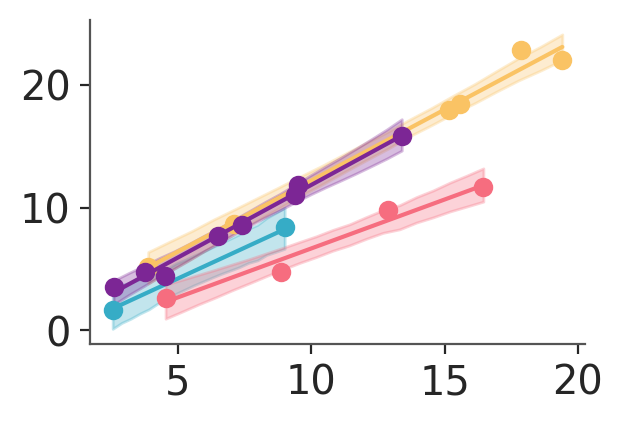

In [14]:
pc = azp.PlotCollection.grid(
    predictions,
    aes={"color": ["group"]},
    figure_kwargs={"figsize": (3, 2)}
)
pc.map(line_band_dots, x_pred=pred_data["x"], x=data["x"], y=data["obs"])

We can radically change the layout of the generated figure without needing to update our plotting functions:

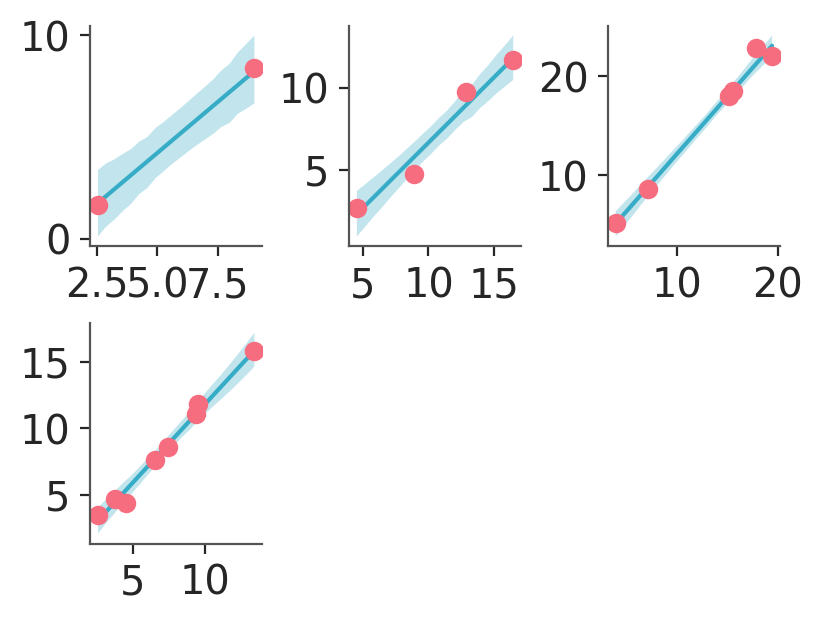

In [15]:
pc = azp.PlotCollection.wrap(
    predictions,
    cols=["group"],
    col_wrap=3,
    figure_kwargs={"figsize": (4, 3)}
)
pc.map(line_band_dots, x_pred=pred_data["x"], x=data["x"], y=data["obs"])

In the plot we have generated, notice that we are not setting color anywhere. In this case, the colors are being set using the defaults of our chosen backend (matplotlib in this case). Recall that in matplotlib, colors automatically cycle each time `.plot` is called on an `Axes` object. As a result, we end up with a blue line and red scatter dots. If we had been using bokeh instead we would have gotten only blue element because bokeh has no automatic cycling built-in.

### Option 2: specific functions for each visual element

Another option, which is what {ref}`batteries-included plots <plots_intro>` do, is writing multiple functions, one for each conceptually different thing to add/do to the plot. To reproduce the example above we'd then need 3 functions: one for the scatter, one for the line and one for the band.

This approach can be harder to get started on, especially if coming from an existing plot as mentioned in the previous section, but it is much more powerful. The main advantage is that we can use different aesthetics in each of the different elements. A secondary advantage is it also allows storing the plotting backend classes representing the different visuals into the `.viz` attribute and to then modify some of them afterwards if desired as shown in {ref}`use_plotcollection`.

Moreover, as this is what batteries-included plots do, there are several such functions ready to use in `arviz_plots.visuals`. That being said, the goal of the library is not to provide a comprehensive catalog of these functions, only to expose the ones available that are used somewhere else within the library.

In this particular case, we can use {func}`arviz_plots.visuals.line_xy` and {func}`arviz_plots.visuals.scatter_xy` so we'll only add a visual specific function for the HDI band.

The `line_xy` function takes the data and plots a line from it, so we'll need to precompute the mean and use that as input. To keep things consistent, we'll do the same for the HDI. This is yet another difference with the case above, but using this pattern will prevent any recomputation every time you want to generate a plot with this data. You'll only need to recompute if you wanted to, for example, change how the data is reduced. It is also worth noting that we could also do this with the monolithic function, we'd only need to add some extra kwargs to take the precomputed quantities.

In [16]:
def hdi_band(da, target, x, **kwargs):
    return target.fill_between(x, da.sel(ci_bound="lower"), da.sel(ci_bound="upper"), **kwargs)

hdi_ds = predictions.azstats.hdi()
mean_ds = predictions.mean(["chain", "draw"])

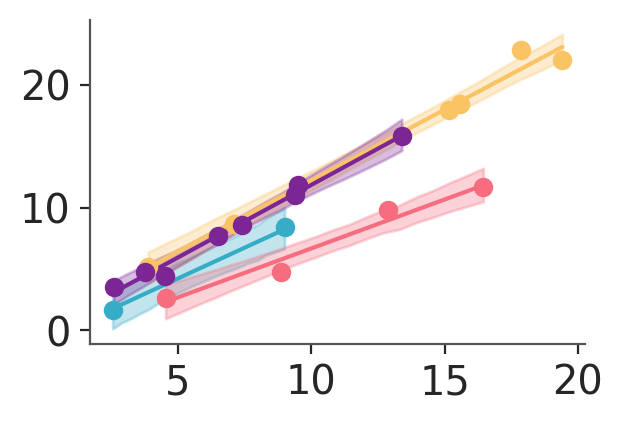

In [17]:
pc = azp.PlotCollection.grid(
    predictions,
    aes={"color": ["group"]},
    figure_kwargs={"figsize": (3, 2)}
)
pc.map(hdi_band, data=hdi_ds, x=pred_data["x"], alpha=0.3)
pc.map(azp.visuals.line_xy, data=mean_ds, x=pred_data["x"])
pc.map(azp.visuals.scatter_xy, y=data["obs"], x=data["x"])

we can also reproduce the other plot we have generated from the monolithic function. We initialize the `PlotCollection` class in the same way,
then call the visual specific functions like we did in the previous cell:

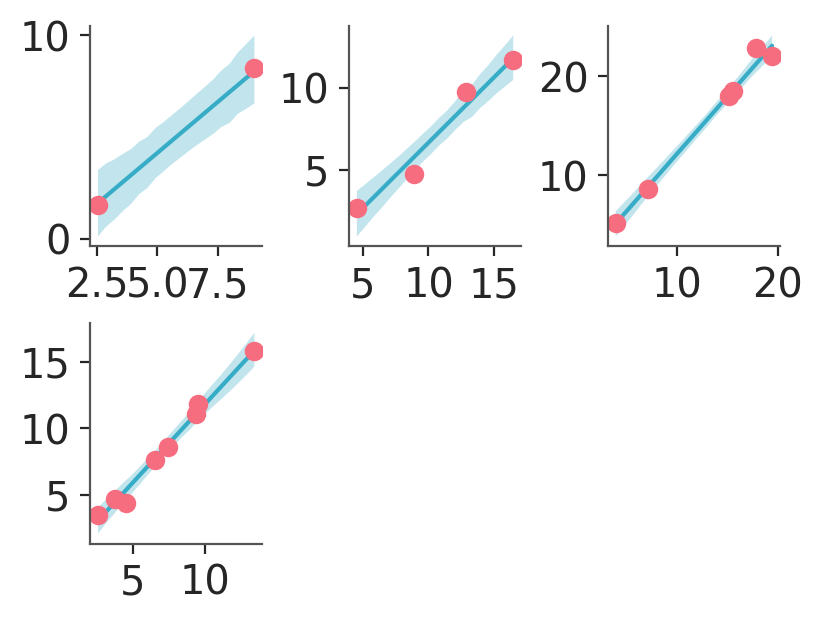

In [18]:
pc = azp.PlotCollection.wrap(
    predictions,
    cols=["group"],
    col_wrap=3,
    figure_kwargs={"figsize": (4, 3)}
)
pc.map(hdi_band, data=hdi_ds, x=pred_data["x"], alpha=0.3)
pc.map(azp.visuals.line_xy, data=mean_ds, x=pred_data["x"])
pc.map(azp.visuals.scatter_xy, y=data["obs"], x=data["x"])

Recall that faceting and aesthetics are independent mappings, allowing for highly flexible customization. For details on how to use those arguments, see `TODO: add reference`.

Moreover, when using visual-specific functions, we can disable aesthetic mappings for some visual elements but leave them active for others. For example, we can keep the group->color mapping and add an extra chain->linestyle mapping, which we'll only use in the line visual element:

In [19]:
# we now need hdi and mean without reducing the "chain" dimension
# so we redefine hdi_ds and mean_ds
hdi_draw_ds = predictions.azstats.hdi(dim=["draw"])
mean_draw_ds = predictions.mean("draw")

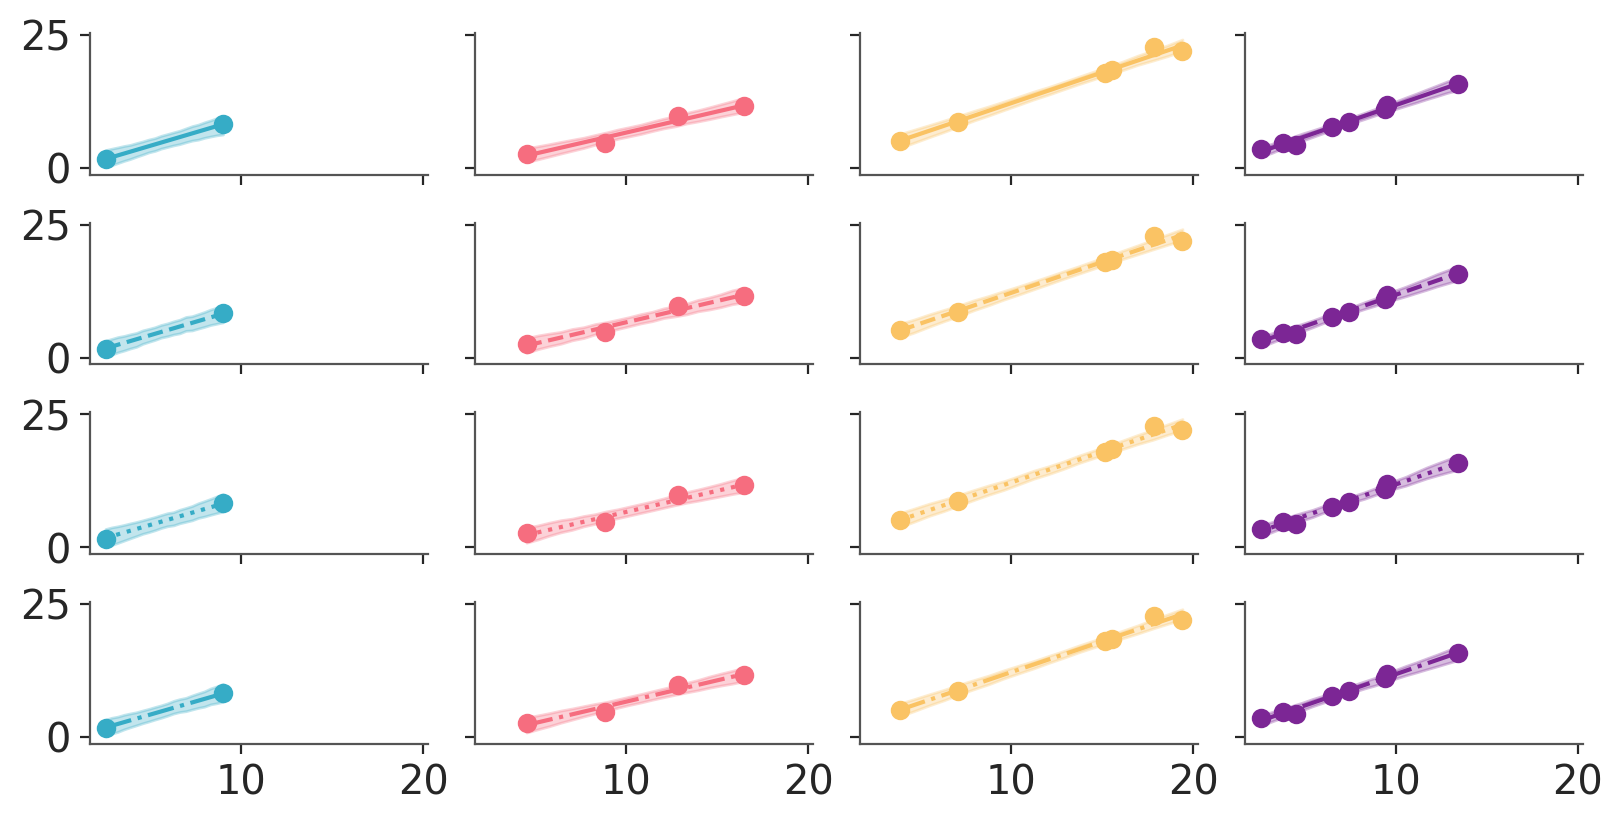

In [20]:
pc_chain = azp.PlotCollection.grid(
    predictions,
    cols=["group"],
    rows=["chain"],
    aes={"color": ["group"], "linestyle": ["chain"]},
    figure_kwargs={"sharex": True, "sharey": True, "figsize": (8, 4)}
)
pc_chain.map(hdi_band, data=hdi_draw_ds, x=pred_data["x"], ignore_aes={"linestyle"}, alpha=0.3)
pc_chain.map(azp.visuals.line_xy, data=mean_draw_ds, x=pred_data["x"])
pc_chain.map(azp.visuals.scatter_xy, y=data["obs"], x=data["x"], ignore_aes={"linestyle"})

which also works without any facetting?

Traceback (most recent call last):
  File "/tmp/ipykernel_21498/2259842625.py", line 9, in <module>
    pc_chain.map(hdi_band, data=hdi_draw_ds, x=pred_data["x"], ignore_aes={"linestyle"}, alpha=0.3)
  File "/home/oriol/Documents/repos_oss/arviz-plots/src/arviz_plots/plot_collection.py", line 1202, in map
    aux_artist = fun(da, target=target, **fun_kwargs)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_21498/2353827776.py", line 2, in hdi_band
    return target.fill_between(x, da.sel(ci_bound="lower"), da.sel(ci_bound="upper"), **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oriol/bin/miniforge3/envs/general/lib/python3.12/site-packages/matplotlib/__init__.py", line 1521, in inner
    return func(
           ^^^^^
  File "/home/oriol/bin/miniforge3/envs/general/lib/python3.12/site-packages/matplotlib/axes/_axes.py", line 5716, in fill_between
    return self._fill_between_x_or_y(
   

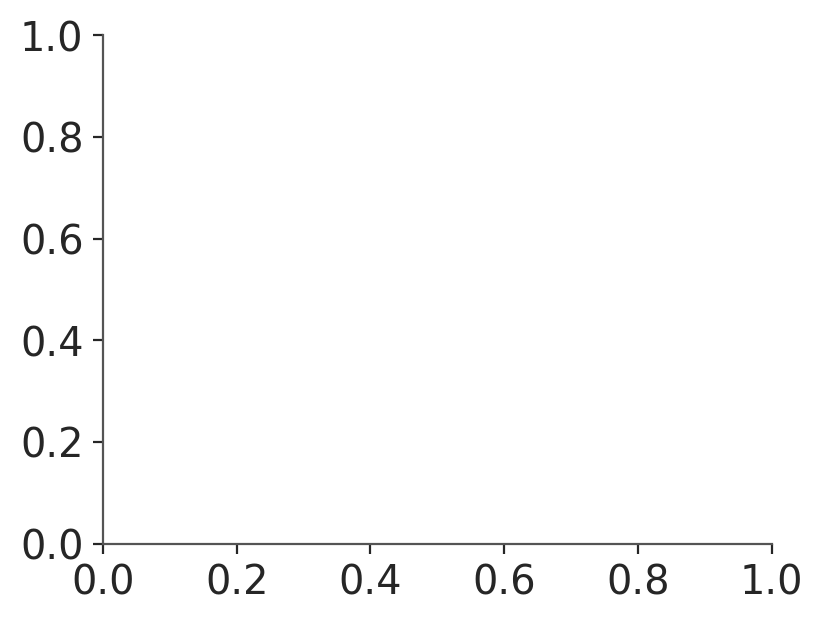

In [21]:
from traceback import print_exception

pc_chain = azp.PlotCollection.grid(
    predictions,
    aes={"color": ["group"], "linestyle": ["chain"]},
    figure_kwargs={"sharex": True, "sharey": True, "figsize": (4, 3)}
)
try:
    pc_chain.map(hdi_band, data=hdi_draw_ds, x=pred_data["x"], ignore_aes={"linestyle"}, alpha=0.3)
    pc_chain.map(azp.visuals.line_xy, data=mean_draw_ds, x=pred_data["x"])
    pc_chain.map(azp.visuals.scatter_xy, y=data["obs"], x=data["x"], ignore_aes={"linestyle"})
except ValueError as err:
    print_exception(err)

The main drawback of the flexibility in faceting, aesthetic mapping and what is allowed as an _aesthetic_ means it is your responsibility to ensure faceting, aesthetic mappings and input data are coherent.

In the above cell we use `hdi_draw_ds` whose `chain` dimension hasn't been reduced. We then ignore the linestyle mapping which is the only one we have for `chain` now. That means that we subset over `group` due to the color aesthetic mapping and pass that result to our `hdi_band` function. The function gets an input with dimensions `chain, obs_id, ci_bound` as it can be seen in the cell below, but `hdi_band` expects `data.sel(ci_bound="lower")` to be unidimensional! Not to still have `chain, obs_id` dimensions!

In [22]:
hdi_draw_ds.query(obs_id="group == 0")

<xarray.Dataset> Size: 2kB
Dimensions:   (chain: 4, obs_id: 20, ci_bound: 2)
Coordinates:
  * chain     (chain) int64 32B 0 1 2 3
  * obs_id    (obs_id) int64 160B 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
    group     (obs_id) int32 80B 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  * ci_bound  (ci_bound) <U5 40B 'lower' 'upper'
Data variables:
    mu        (chain, obs_id, ci_bound) float64 1kB 0.1445 3.387 ... 6.646 9.979

If we want a single HDI band per group, we should fix this updating the data to `hdi_ds` where we have already reduced the `chain` dimension:

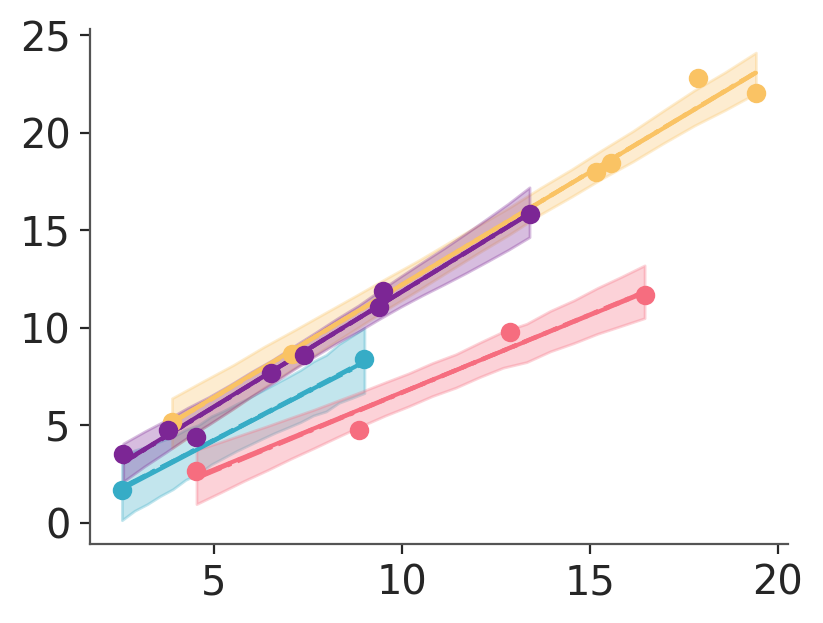

In [23]:
pc_chain = azp.PlotCollection.grid(
    predictions,
    aes={"color": ["group"], "linestyle": ["chain"]},
    figure_kwargs={"sharex": True, "sharey": True, "figsize": (4, 3)}
)
pc_chain.map(hdi_band, data=hdi_ds, x=pred_data["x"], ignore_aes={"linestyle"}, alpha=0.3)
pc_chain.map(azp.visuals.line_xy, data=mean_draw_ds, x=pred_data["x"])
pc_chain.map(azp.visuals.scatter_xy, y=data["obs"], x=data["x"], ignore_aes={"linestyle"})

If instead we want one band per group and per chain, we have to fix the error by making sure even if we disable the linestyle mapping, there will be something mapped to the `chain` dimension. We will use a mapping on the hatch property to that effect. We will then ignore the hatch mapping for the line and the linestyle mapping for the band:

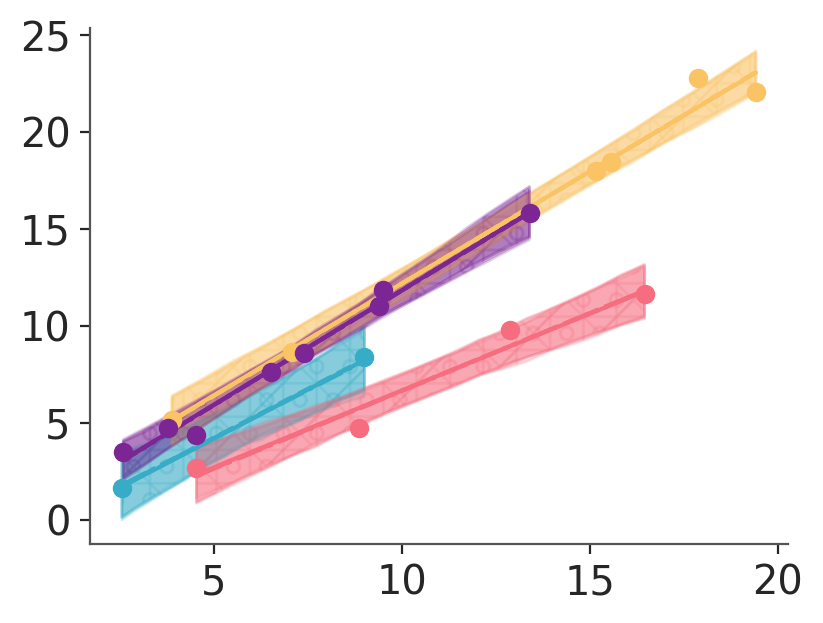

In [24]:
pc_chain = azp.PlotCollection.grid(
    predictions,
    aes={"color": ["group"], "linestyle": ["chain"], "hatch": ["chain"]},
    figure_kwargs={"sharex": True, "sharey": True, "figsize": (4, 3)},
    hatch=["/", "+", "x", "o"],
)
pc_chain.map(hdi_band, data=hdi_draw_ds, x=pred_data["x"], ignore_aes={"linestyle"}, alpha=0.2)
pc_chain.map(azp.visuals.line_xy, data=mean_draw_ds, x=pred_data["x"], ignore_aes={"hatch"})
pc_chain.map(azp.visuals.scatter_xy, y=data["obs"], x=data["x"], ignore_aes={"linestyle", "hatch"})

:::{seealso}
* coming soon: In depth explanation of how faceting and aesthetics are handled
* {ref}`plots_intro/advanced` has advanced examples using batteries-included plots using complex combinations of faceting and aesthetic mappings.
* {ref}`add_new_plot` is a guide for contributors and developers working on batteries-included plots. If you are using `PlotCollection` to generate domain specific plots included in another library it will probably be helpful to you as it covers internal scaffolding to for example know which dimensions to reduce based on `sample_dims` input and existing aesthetic mappings.
:::